# **Literature Review**


1. [The determinants of the salary in NBA and the overpayment in the year of signing a new contract](https://www.proquest.com/docview/1654415245)
2. [National Basketball Association Player Salary Prediction Using Supervised Machine Learning Methods](https://doi.org/10.1007/978-3-030-85577-2_22)
3. [Estimating NBA players salary share according to their performance on court: A machine learning approach ](https://doi.org/10.48550/arXiv.2007.14694)




##### Other references
1. [Classification of NBA Salaries through Player
Statistics](https://sportsanalytics.berkeley.edu/projects/nba-salaries-stats.pdf) (not peer-reviewed)

# **Data**

#### [sumitrodatta's contract prediction](https://github.com/sumitrodatta/contract-prediction-2022/tree/main/Data)

# **Code**

## **Data Preparation**

In [ ]:
#@title Load dependency
import pandas as pd

In [ ]:
#@title Function to convert name format to match Basketball Reference
def rename_to_bbref(df):
    df = df.replace("Lonnie Walker", "Lonnie Walker IV")
    df = df.replace("Nicolas Claxton", "Nic Claxton")
    df = df.replace("Robert Woodard", "Robert Woodard II")
    df = df.replace("Goran Dragic", "Goran Dragić")
    df = df.replace("Jonas Valanciunas", "Jonas Valančiūnas")
    df = df.replace("Jusuf Nurkic", "Jusuf Nurkić")
    df = df.replace("Tomas Satoransky", "Tomáš Satoranský")
    df = df.replace("Vlatko Cancar", "Vlatko Čančar")
    df = df.replace("Danuel House", "Danuel House")
    df = df.replace("Patrick Mills", "Patty Mills")
    df = df.replace("James Ennis", "James Ennis III")
    df = df.replace("Danuel House", "Danuel House Jr.")
    df = df.replace("Wesley Iwundu", "Wes Iwundu")
    df = df.replace("Juan Hernangómez", "Juancho Hernangómez")
    df = df.replace("Charlie Brown", "Charlie Brown Jr.")
    df = df.replace("Otto Porter", "Otto Porter Jr.")
    df = df.replace("Enes Kanter", "Enes Freedom")
    df = df.replace("Sviatoslav Mykhailiuk", "Svi Mykhailiuk")
    return df

In [ ]:
#@title Read data

# Load player_id
url = "https://raw.githubusercontent.com/spectrumsing/NBA-Contract-Prediction/main/Data/player_id.txt"
player_id = pd.read_csv(url)
player_id = player_id.drop_duplicates(subset = ["player_id"])


# Load 2022 free agents contract length

url = "https://raw.githubusercontent.com/spectrumsing/NBA-Contract-Prediction/main/Data/Free%20Agents%202022.csv"
FA_2022 = pd.read_csv(url)
FA_2022["player"] = rename_to_bbref(FA_2022["player"])
FA_2022 = pd.merge(FA_2022, player_id, on = ["player"], how = "left")
FA_2022 = FA_2022.replace("-", 0)
FA_2022["contract_yrs"] = FA_2022["contract_yrs"].astype(int)

## Set contract_yrs to 0 players who signed Exhibit 9/10, two-way, and non-guaranteed contracts

terms = pd.read_csv("https://raw.githubusercontent.com/spectrumsing/NBA-Contract-Prediction/main/Data/terms.txt")
FA_2022 = pd.merge(FA_2022, terms[["player_id", "terms"]],
                   on = "player_id",
                   how = "left")
FA_2022["terms"] = FA_2022["terms"].fillna("Did not sign with NBA team")
FA_2022["contract_yrs"] = FA_2022.apply(lambda x: 0
                                        if ("two-way" in x["terms"].lower() or
                                            "exhibit" in x["terms"].lower() or
                                            "non-guaranteed" in x["terms"].lower() or
                                            "did not sign" in x["terms"].lower())
                                        else x["contract_yrs"],
                                        axis = 1)


# Load 2022-23 salary and convert salary to interger

url = "https://raw.githubusercontent.com/spectrumsing/NBA-Contract-Prediction/main/Data/2022-23%20salary.txt"
sal_2023 = pd.read_csv(url, header = 1)
sal_2023["2022-23"] = sal_2023["2022-23"].str.lstrip("$")
sal_2023["2022-23"] = pd.to_numeric(sal_2023["2022-23"])
sal_2023 = sal_2023.rename(columns = {"Player": "player"})


# Load 2016-2021 and 2022 free agents stats
## 2016-2021
url = "https://raw.githubusercontent.com/sumitrodatta/contract-prediction-2022/main/Data/Train%20Set.csv"
stat_2021 = pd.read_csv(url)
stat_2021["player"] = rename_to_bbref(stat_2021["player"])
stat_2021 = stat_2021.drop(columns = "player_id")
stat_2021 = pd.merge(stat_2021, player_id,
                     on = "player",
                     how = "inner") # attach player_id

## 2022
url = "https://raw.githubusercontent.com/sumitrodatta/contract-prediction-2022/main/Data/Eval%20Set.csv"
stat_2022 = pd.read_csv(url)
stat_2022["player"] = rename_to_bbref(stat_2022["player"])
stat_2022 = stat_2022.drop(columns = ["player_id", "contract_yrs"])
cap_2023 = 112414000
stat_2022 = pd.merge(stat_2022, player_id,
                     on = "player",
                     how = "inner") # attach player_id

### Remove players that exercised options
terms["terms"] = terms["terms"].fillna("Did not sign with NBA team")
option = terms[terms["terms"].str.contains("option")] # filter player that exercised option
pd.merge(option, stat_2022[["player_id"]],
         on = "player_id",
         how = "inner")
diff = pd.merge(stat_2022, option[["player_id"]],
                on = "player_id",
                how = "outer",
                indicator = True)
stat_2022 = diff[diff["_merge"] == "left_only"]
stat_2022 = stat_2022.drop(columns = "_merge")

stat_2022 = pd.merge(stat_2022, FA_2022[["player_id", "contract_yrs"]],
                     on = "player_id",
                     how = "inner") # attach contract length
stat_2022 = pd.merge(stat_2022, sal_2023[["player", "2022-23"]],
                     on = 'player',
                     how = 'left') # attach 2022-23 season salary
stat_2022 = stat_2022.drop_duplicates(subset = "seas_id")
stat_2022["2022-23"] = stat_2022["2022-23"].fillna(0)
stat_2022["first_year_percent_of_cap"] = stat_2022["2022-23"] / cap_2023 # calculate first year percent of cap
stat_2022 = stat_2022.drop(columns = "2022-23")



# Load RAPTOR

url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-raptor/modern_RAPTOR_by_player.csv"
RAPTOR = pd.read_csv(url)
RAPTOR = RAPTOR[RAPTOR["season"] >= 2016]
RAPTOR = RAPTOR.rename(columns = {"player_name": "player"})

In [ ]:
#@title Construct data set

# Merge 2016-21 and 2022

stat = pd.concat([stat_2021, stat_2022], sort = False)
stat = stat.drop_duplicates(subset = ["seas_id"])

# Attach RAPTOR and WAR to stat

stat_RAPTOR = pd.merge(stat, RAPTOR[["player_id", "season", "raptor_total", "war_total"]],
                       on = ['player_id', 'season'],
                       how = 'inner')


# Drop rolling 3 yr stats, steals, VORP, Win shares

stat_RAPTOR = stat_RAPTOR.drop(["stl_per_game", "ows", "dws", "ws_per_48", "vorp", "percent_of_pos_vorp"], axis = 1)
stat_RAPTOR = stat_RAPTOR[stat_RAPTOR.columns.drop(list(stat_RAPTOR.filter(regex = "3_yrs")))]

# Final data set
stat_RAPTOR

,seas_id,season,player,age,experience,g_percent,gs_percent,mp_per_game,x3p_per_game,x3pa_per_game,...,x3p_percent,x2p_percent,e_fg_percent,ft_percent,type,contract_yrs,first_year_percent_of_cap,player_id,raptor_total,war_total
0,25747,2016,Aaron Brooks,31,8,0.8415,0.0000,16.0580,0.9565,2.6812,...,0.3568,0.4296,0.4712,0.7656,UFA,1,0.028700,brookaa01,-0.762820,1.119933
1,26326,2017,Aaron Brooks,32,9,0.7927,0.0000,13.7538,0.7385,1.9692,...,0.3750,0.4244,0.4833,0.8000,UFA,1,0.021400,brookaa01,-3.126255,-0.175477
2,26920,2018,Aaron Brooks,33,10,0.3902,0.0312,5.9062,0.3438,0.9688,...,0.3548,0.4474,0.4855,0.7273,UFA,0,0.000000,brookaa01,-6.751122,-0.392122
3,25751,2016,Al Horford,29,9,1.0000,1.0000,32.0854,1.0732,3.1220,...,0.3438,0.5568,0.5468,0.7984,UFA,4,0.281900,horfoal01,1.644356,6.667131
4,27587,2019,Al Horford,32,12,0.8293,1.0000,29.0147,1.0735,2.9853,...,0.3596,0.6038,0.5858,0.8211,UFA,4,0.256600,horfoal01,3.766339,7.618132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,30441,2022,Wesley Matthews,35,13,0.5976,0.2857,20.4490,1.0816,3.2041,...,0.3376,0.5397,0.5159,0.7857,UFA,1,0.016333,matthwe02,1.704555,3.105204
1385,30447,2022,Xavier Moon,27,1,0.1220,0.0000,13.7000,0.5000,1.4000,...,0.3571,0.5405,0.5392,0.6000,RFA,0,0.000000,moonxa01,0.004853,0.191322
1386,30452,2022,Yuta Watanabe,27,4,0.4634,0.1053,11.7105,0.7105,2.0789,...,0.3418,0.4915,0.5036,0.6000,RFA,0,0.016333,watanyu01,-5.072586,-0.538251
1387,30453,2022,Yves Pons,22,1,0.1463,0.0000,5.9167,0.2500,0.7500,...,0.3333,0.2857,0.4062,0.0000,RFA,0,0.000000,ponsyv01,-6.806673,-0.147032


## **Model**

In [ ]:
# Preprocessing and Split Train-Test

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

outcome = 'first_year_percent_of_cap'
interest_vars = ['age','experience','g_percent','gs_percent','mp_per_game','x3p_per_game','x3pa_per_game','x2p_per_game','x2pa_per_game','ft_per_game','fta_per_game',
                    'orb_per_game','drb_per_game','ast_per_game','blk_per_game','tov_per_game','pf_per_game','fg_percent','x3p_percent','x2p_percent','e_fg_percent',
                    'ft_percent','raptor_total','war_total']

shuffled = shuffle(stat_RAPTOR, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(shuffled[interest_vars], shuffled[outcome], test_size = 0.2, random_state = 1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
## Decision Tree, Random Forest, Gradient Boosting & XGBoost Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

decision_tree = DecisionTreeRegressor(random_state=0)
random_forest = RandomForestRegressor(random_state=0)
GBC = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_leaf_nodes = None, criterion = "squared_error", random_state=0)
XGBC = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_leaves = 0, booster = "gbtree", tree_method = "exact", grow_policy = "lossguide", objective = "reg:logistic", random_state=0)

In [ ]:
# Evaluating Models

predictor_list = [decision_tree, random_forest, GBC, XGBC]
predictor_list_names = ["Decision Tree", "Random Forest", "Gradient Boosting ", "XGBoost"]

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


r2_scores = []
mae = []
mse = []
cvs = []
cvs_mean = []
cvs_std = []

for predictor in predictor_list:
    predictor.fit(x_train_scaled, y_train)
    # Scores:
    r2_scores.append(r2_score(y_test, predictor.predict(x_test_scaled)))
    mse.append(mean_squared_error(y_test, predictor.predict(x_test_scaled)))
    mae.append(mean_absolute_error(y_test, predictor.predict(x_test_scaled)))
    # Cross Validation Scores:
    cross_val = cross_val_score(predictor, scaler.transform(shuffled[interest_vars]), shuffled[outcome], cv = 5)
    cvs.append(cross_val)
    cvs_mean.append(cross_val.mean())
    cvs_std.append(cross_val.std())

# Let's set up a Pandas dataframe for ease of comparison:
raw_comparison = list(zip(predictor_list_names, r2_scores, mae, mse, cvs, cvs_mean, cvs_std))
comparison = pd.DataFrame(raw_comparison, columns = ["Predictor", "Score", "Mean Absolute Error", "Mean Squared Error", "Cross Validation Score (CVS)", "CVS Mean", "CVS Standard Deviation"])

In [ ]:
comparison

,Predictor,Score,Mean Absolute Error,Mean Squared Error,Cross Validation Score (CVS),CVS Mean,CVS Standard Deviation
0,Decision Tree,0.506918,0.024409,0.001945,"[0.5261306958578209, 0.527112908206969, 0.4852...",0.541496,0.041196
1,Random Forest,0.795617,0.017873,0.000806,"[0.7090228475087292, 0.7619964931086317, 0.748...",0.734524,0.020806
2,Gradient Boosting,0.777262,0.018326,0.000878,"[0.7044395873329947, 0.7532656006902594, 0.718...",0.715102,0.024442
3,XGBoost,0.797113,0.017782,0.000800,"[0.7272671892064813, 0.7334220081862162, 0.744...",0.727083,0.021329


In [ ]:
#@title Fork model

# Preprocessing and Split Train-Test

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

outcome = 'first_year_percent_of_cap'
interest_vars = ['age','experience','x3p_per_game','x3pa_per_game','x2p_per_game','x2pa_per_game','ft_per_game','fta_per_game',
                    'orb_per_game','drb_per_game','ast_per_game','blk_per_game','tov_per_game','pf_per_game','fg_percent','x3p_percent','x2p_percent','e_fg_percent',
                    'ft_percent','raptor_total','war_total']

shuffled = shuffle(stat_RAPTOR, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(shuffled[interest_vars], shuffled[outcome], test_size = 0.2, random_state = 1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Decision Tree, Random Forest, Gradient Boosting & XGBoost Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

decision_tree = DecisionTreeRegressor(random_state=0)
random_forest = RandomForestRegressor(random_state=0)
GBC = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_leaf_nodes = None, criterion = "squared_error")
XGBC = xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_leaves = 0, booster = "gbtree", tree_method = "exact", grow_policy = "lossguide", objective = "reg:logistic")

# Evaluating Models

predictor_list = [decision_tree, random_forest, GBC, XGBC]
predictor_list_names = ["Decision Tree", "Random Forest", "Gradient Boosting Classifier", "XGBoost Classifier"]

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


r2_scores = []
mae = []
mse = []
cvs = []
cvs_mean = []
cvs_std = []

for predictor in predictor_list:
    predictor.fit(x_train_scaled, y_train)
    # Scores:
    out = predictor.predict(x_test_scaled)
    r2_scores.append(r2_score(y_test, out))
    mse.append(mean_squared_error(y_test, out))
    mae.append(mean_absolute_error(y_test, out))
    # Cross Validation Scores:
    cross_val = cross_val_score(predictor, scaler.transform(shuffled[interest_vars]), shuffled[outcome], cv = 5)
    cvs.append(cross_val)
    cvs_mean.append(cross_val.mean())
    cvs_std.append(cross_val.std())

# Let's set up a Pandas dataframe for ease of comparison:
raw_comparison = list(zip(predictor_list_names, r2_scores, mae, mse, cvs, cvs_mean, cvs_std))
comparison = pd.DataFrame(raw_comparison, columns = ["Predictor", "Score", "Mean Absolute Error", "Mean Squared Error", "Cross Validation Score (CVS)", "CVS Mean", "CVS Standard Deviation"])

In [ ]:
#@title Market inefficiency

# function to get total difference in percentage cap
def mismatch(stat, method):
  stat_scaled = scaler.transform(stat[interest_vars])
  prediction = pd.DataFrame(method.predict(stat_scaled), columns=["predicted"])
  df = pd.concat([stat, prediction.set_index(stat.index)], axis=1, sort=False)
  df["diff"] = df["first_year_percent_of_cap"] - df["predicted"].values
  df = df[["player", "season", "age", "experience", "first_year_percent_of_cap", "predicted", "diff"]]
  return df

# entire data set from 2016-22
stat_RAPTOR_mismatch = mismatch(stat_RAPTOR, random_forest)
## total mismatch in percentage of cap
sum(abs(stat_RAPTOR_mismatch["diff"]))


14.700703032202386

In [ ]:
## most overpaid
stat_RAPTOR_mismatch.nlargest(5, "diff")

,player,season,age,experience,first_year_percent_of_cap,predicted,diff
340,Timofey Mozgov,2016,29,6,0.170000,0.034011,0.135989
530,Otto Porter Jr.,2017,23,4,0.250000,0.126501,0.123499
87,Dirk Nowitzki,2016,37,18,0.265600,0.155813,0.109787
913,Klay Thompson,2019,28,8,0.300000,0.194008,0.105992
1243,Bradley Beal,2022,28,10,0.384999,0.292444,0.092555


In [ ]:
## most underpaid
stat_RAPTOR_mismatch.nsmallest(5, "diff")

,player,season,age,experience,first_year_percent_of_cap,predicted,diff
1226,Victor Oladipo,2021,28,8,0.0213,0.136921,-0.115621
13,Andre Drummond,2021,27,9,0.0214,0.133593,-0.112193
622,Carmelo Anthony,2018,33,15,0.0235,0.129099,-0.105599
654,DeMarcus Cousins,2019,28,9,0.0321,0.122636,-0.090536
1339,Miles Bridges,2022,23,4,0.0000,0.088592,-0.088592


In [ ]:
## big names
stars = stat_RAPTOR[stat_RAPTOR["player"].str.contains("Nikola Jokić|Kevin Durant|Stephen Curry|LeBron James|Joel Embiid|Kawhi Leonard")].sort_values(by="player")
mismatch(stars, random_forest)

,player,season,age,experience,first_year_percent_of_cap,predicted,diff
903,Kawhi Leonard,2019,27,8,0.3000,0.295933,0.004067
904,Kawhi Leonard,2021,29,10,0.3500,0.334904,0.015096
209,Kevin Durant,2016,27,9,0.2819,0.283606,-0.001706
210,Kevin Durant,2017,28,10,0.2523,0.267649,-0.015349
211,Kevin Durant,2018,29,11,0.2945,0.288708,0.005792
212,Kevin Durant,2019,30,12,0.3408,0.291265,0.049535
230,LeBron James,2016,31,13,0.3289,0.328215,0.000685
231,LeBron James,2018,33,15,0.3500,0.325858,0.024142
744,Nikola Jokić,2018,22,3,0.2458,0.251967,-0.006167
564,Stephen Curry,2017,28,8,0.3500,0.333858,0.016142


In [ ]:
 # KNN
# Assign train_y into clusters
from sklearn.neighbors import KNeighborsClassifier

def salary_cluster(value):
    if value <= 0.02:
        return 1
    elif value <= 0.04 :
        return 2
    elif value <= 0.07:
        return 3
    elif value <= 0.1:
        return 4
    elif value <= 0.13:
        return 5
    elif value <= 0.16:
      return 6
    elif value <= 0.19:
      return 7
    else:
      return 8

y_train_cluster = y_train.apply(lambda row: salary_cluster(row))
y_test_cluster = y_test.apply(lambda row: salary_cluster(row))

# Change Clusters to factors
from sklearn import preprocessing
from sklearn import utils
lab = preprocessing.LabelEncoder()
y_train_cluster = lab.fit_transform(y_train_cluster)
y_test_cluster = lab.fit_transform(y_test_cluster)

# Find Optimal K
Scores = {}

for k in range(1, 101):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train_scaled, y_train_cluster)
    Scores[str(k)] = neigh.score(x_test_scaled, y_test_cluster)

#Now to determine the key that corresponds to the maximum value in the dictionary

print(f'Optimal k is equal to {max(Scores, key=Scores.get)} which returns a score of {Scores[str(5)]}.')

# Gather predicted values for test


neigh = KNeighborsClassifier(n_neighbors=17)
neigh.fit(x_train_scaled, y_train_cluster)
predicted_values = neigh.predict(x_test_scaled)

#Accuracy Rate
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_cluster, predicted_values))
#Predict Full data set
d1 = pd.DataFrame(x_train_scaled)
d2 = pd.DataFrame(x_test_scaled)
d3 = pd.concat([d1,d2])

predicted_values_full = neigh.predict(d3)
plt.hist(predicted_values, bins=10, alpha=0.5)



Optimal k is equal to 17 which returns a score of 0.5935251798561151.
Accuracy: 0.6402877697841727


NameError: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(random_forest.feature_importances_,x_test.columns,"RANDOM FOREST")
plot_feature_importance(decision_tree.feature_importances_,x_test.columns,"DECISION TREE")
plot_feature_importance(GBC.feature_importances_,x_test.columns,"GRADIENT BOOSTING")
plot_feature_importance(XGBC.feature_importances_,x_test.columns,"XG BOOST")

# **EDA**

## Correlation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rcParams
sns.set_style("white")

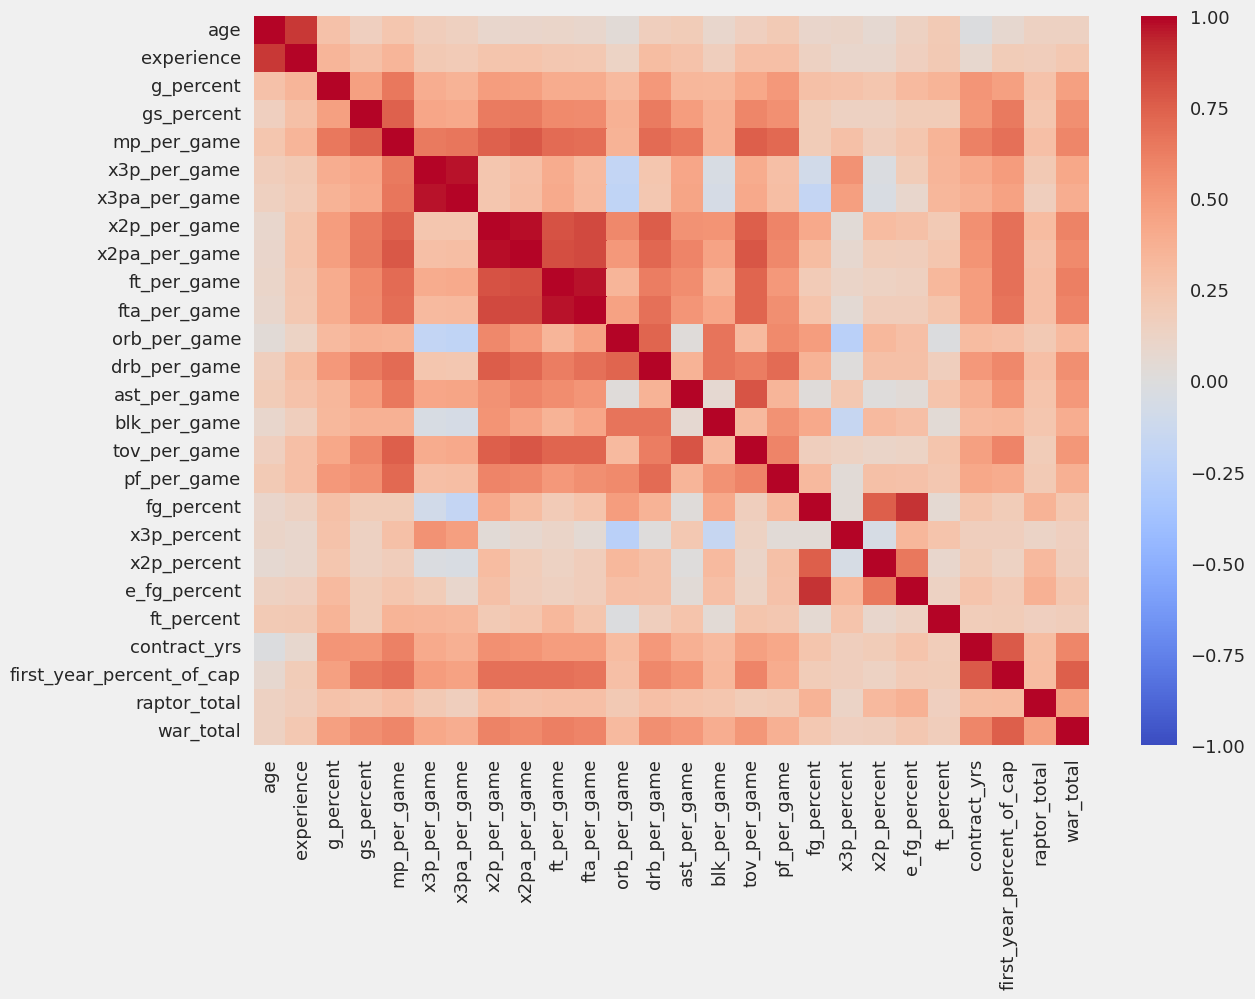

In [ ]:
#@title Variable correlation
plt.figure(figsize = (12,9), dpi=100)
sns.heatmap(stat_RAPTOR.drop(["seas_id", "season", "player", "type", "player_id"], axis = 1).corr(),
                   vmin = -1,
                   vmax = 1,
                   cmap = "coolwarm")
plt.tick_params(left = False, bottom = False)

[None, None, None, None, None, None, None, None, None, None, None, None]

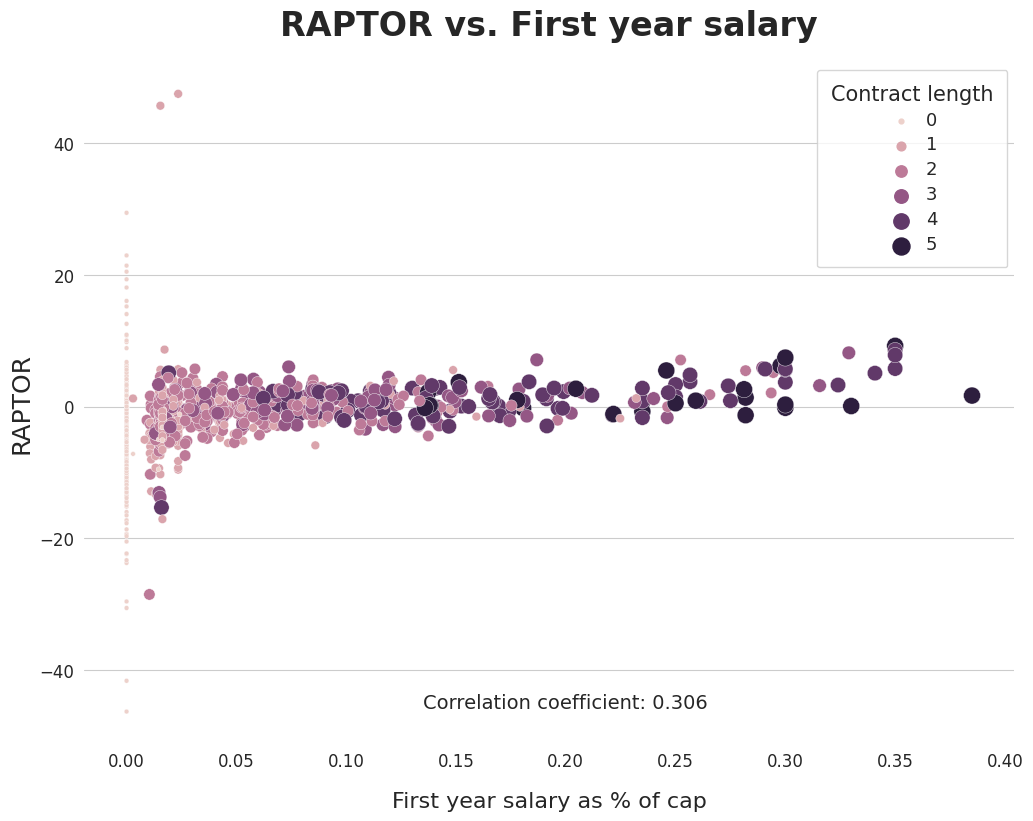

In [ ]:
#@title RAPTOR first year salary correlation
plt.figure(figsize=(12, 9), dpi=100)
raptor_plot = sns.scatterplot(data=stat_RAPTOR,
                x="first_year_percent_of_cap",
                y="raptor_total",
                hue="contract_yrs",
                size="contract_yrs",
                sizes=(12, 150),
                )
sns.despine(left=True, bottom=True)
plt.grid(True, axis="y")
plt.title("RAPTOR vs. First year salary", fontsize=24, weight="semibold", pad=20)
plt.ylabel("RAPTOR", fontsize=18, weight="medium")
plt.xlabel("First year salary as % of cap", fontsize=16, weight="medium", labelpad=15)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.text(0.2, -45,
         "Correlation coefficient: " + str(round(stat_RAPTOR["first_year_percent_of_cap"].corr(stat_RAPTOR["raptor_total"]), 3)),
         fontsize=14,
         weight="medium",
         ha="center",
         va="center",
         )
plt.legend(title="Contract length", borderpad=1)
plt.setp(raptor_plot.get_legend().get_title(), fontsize=15, weight="medium")
plt.setp(raptor_plot.get_legend().get_texts(), fontsize=13)

In [ ]:
descript = pd.DataFrame([stat_RAPTOR["first_year_percent_of_cap"].describe(), stat_RAPTOR["raptor_total"].describe()]).T
descript.columns = ["First year salary", "RAPTOR"]
descript

,First year salary,RAPTOR
count,1389.000000,1389.000000
mean,0.039650,-1.818240
std,0.064813,5.296957
min,0.000000,-46.307943
25%,0.000000,-3.845888
50%,0.015900,-1.472998
75%,0.044500,0.665477
max,0.384999,47.473611
